In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np


import numpy as np
from bertopic import BERTopic
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm



In [104]:
# import pandas as pd

# Read the first few rows from the CSV file
df = pd.read_csv('Ola Customer Reviews.csv', nrows=80000)


# Display the first few rows of the dataframe
df.head()



,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,Google Play,fbc7ffc9-5a89-446e-87fd-d69bf4a7f984,Puipuii Ralte,NaN,"The map in Ola is so messed up, i have to pay ...",1,0,2023-08-10 16:40:50,NaN,NaN,6.3.2,en,in
1,Google Play,5a0051fb-220a-45b2-ba94-a15a2949218f,Deepak Kumar,NaN,Deepak Kumar.... 🙏🙏🙏🙏🙏],5,0,2023-08-10 16:36:14,NaN,NaN,NaN,en,in
2,Google Play,71ebf933-b734-474d-bb65-a18c90906ed2,Ahamed Azarudeen,NaN,Such aa irresponsible app more then I waiting ...,1,0,2023-08-10 16:29:31,NaN,NaN,6.3.1,en,in
3,Google Play,e1cc0010-60b3-4126-99c2-e8549088566a,Rahil Syed,NaN,Worst,1,0,2023-08-10 15:52:06,NaN,NaN,5.0.4,en,in
4,Google Play,77cf1be1-b428-4493-ae25-e0f288f79b8f,vin 007,NaN,Too much expensive .. try UBer... They are pro...,1,0,2023-08-10 15:51:10,NaN,NaN,NaN,en,in


In [105]:
# 
# Pre-processing 1: Preprocessing function using TensorFlow
# 
# 
def preprocess_text(text):
    # Convert to lowercase
    text = tf.strings.lower(text)
    # Remove HTML tags
    text = tf.strings.regex_replace(text, r'<.*?>', '')
    # Remove non-alphabet characters
    text = tf.strings.regex_replace(text, r'[^a-zA-Z\s]', '')
    # Strip leading and trailing whitespaces
    text = tf.strings.strip(text)
    return text.numpy().decode('utf-8')

# Remove rows with NaN values in the review_text column
df = df.dropna(subset=['review_description'])

# Select rows where the length of review_description is greater than or equal to 20 characters
df = df[df['review_description'].str.len() >= 20]

# Check the number of rows in the DataFrame after removing NaN values
num_rows = len(df)
print(f"Number of rows in the DataFrame after removing NaN values: {num_rows}")

# Apply preprocessing
df['cleaned_review'] = df['review_description'].apply(lambda x: preprocess_text(tf.convert_to_tensor(x)))


# Display the first few rows of the dataframe with cleaned reviews
df[['review_description', 'cleaned_review']].head()


# Check for NaN values in the review_text column
nan_count = df['cleaned_review'].isna().sum()
print(f"Number of NaN values in review_text column: {nan_count}")

Number of rows in the DataFrame after removing NaN values: 59927
Number of NaN values in review_text column: 0


In [9]:
# 
# Pre-processing 2: Train a count vecotrizer to identify stopwords
# 
# 

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text using CountVectorizer with n-grams
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_review'])

# Display the top n-grams
feature_names = vectorizer.get_feature_names_out()
print(len(feature_names))

# Get the feature names (keys)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts of each feature across all documents
feature_counts = X.toarray().sum(axis=0)

# Create a DataFrame to display feature names and their counts
feature_df = pd.DataFrame({'feature': feature_names, 'count': feature_counts})
print(feature_df)

feature_df.to_csv('count_vector.csv', index = False)

2873
     feature  count
0         aa     15
1      aadhe      3
2        aaj     11
3        aap     61
4      aapka      2
...      ...    ...
2868   youre     10
2869   youve      5
2870    zada      4
2871    zero     34
2872   zyada      2

[2873 rows x 2 columns]


In [106]:
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Download stop words
nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# Sample Hinglish stopwords list (you can expand this list)
hinglish_stopwords = {
    'hai', 'ho', 'main', 'mein', 'tum', 'kya', 'kyun', 'ke', 'ko', 'se', 'ka', 'ki', 'par', 
    'ek', 'aur', 'aur', 'hi', 'kar', 'raha', 'rahe', 'rahi', 'tha', 'thi', 'the', 'hai', 
    'hun', 'hona', 'diya', 'gaya', 'ke', 'ko', 'ne', 'se', 'me', 'ka', 'ki', 'ho', 'kyun',
    'nahi', 'nhi', 'bhi', 'koi', 'kiya', 'ye', 'aap', 'na', 'hota', 'jab', 'tab', 'bahut',
    'dete', 'bar', 'karte', 'kabhi', 'tabhi', 'karo', 'kam', 'kr', 'pe', 'phir', 'sabse',
    'best', 'good', 'worst', 'ola', 'nice', 'wrost', 'ghatiya', 'bekar', 'bakwas', 'fir', 'baad',
    'hain', 'mujhe', 'le', 'jana', 'liye', 'hu', 'de', 'karta', 'karne', 'wale', 'karna', 'ni', 'mera',
    'kuch', 'ha', 'tak', 'aapne', 'main', 'apne', 'jo', 'mene', 'mein', 'pr', 'mere',
    "ola", "worst", "dont", "bad", "use", "rs", "just", "times", "pathetic",
    "hai", "good", "way", "didnt", "better", "want", "using", "got", "like",
    "im", "se", "wont", "ke", "nhi", "aap", "kar", "does", "bhi", "nahi", "ka",
    "hi", "ki", "unki"
}





# Get English stopwords from NLTK
english_stopwords = set(stopwords.words('english'))

# Combine Hinglish and English stopwords
combined_stopwords = hinglish_stopwords.union(english_stopwords)

print(combined_stopwords)



# Function to remove stop words and lemmatize documents
def remove_stopwords(doc):
    tokens = doc.split()
    tokens = [word for word in tokens if word.lower() not in combined_stopwords]
    tokens = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in tokens]
    return ' '.join(tokens)

# Remove stop words from the reviews
df['cleaned_review'] = df['cleaned_review'].apply(remove_stopwords)
# Select rows where the length of review_description is greater than or equal to 100 characters
df = df[df['cleaned_review'].str.len() >= 20]
# # Add a new column 'review_length' that contains the length of each review
# # df['review_length'] = df['cleaned_review'].str.len()
print(df.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulpoonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'the', 'their', 'then', 'been', 'ourselves', 'most', 'mightn', "haven't", 'its', 'having', 'where', 'can', 'because', 'that', 'ke', 'had', 'above', 'jo', 'few', 'your', 'ni', "she's", 'them', 'kya', "shan't", 'karte', 'pe', 'don', 'de', 've', 'raha', 'bekar', 'has', 'to', "couldn't", 'mujhe', 'aapne', 'kam', "it's", 'doing', 'using', 'any', 't', 'were', 'have', 'kuch', 'ha', 'aur', 'worst', 'y', 'kabhi', "won't", 'after', 'hai', 'itself', 'bahut', 'it', 'same', 'sabse', 'hota', 'didnt', 'better', 'mene', 'more', 'you', 'from', 'and', 'rahe', 'rahi', 'hain', 'is', 'll', 'dont', 'fir', 'until', 'when', "don't", 'does', 'wale', 'did', 'before', 'as', 'theirs', 'some', "aren't", 'ma', 'my', 'tab', 'tum', 'use', 'ye', 'im', "hasn't", 'ho', 'against', 'himself', 'themselves', 'than', 'mein', 'ek', 'down', 'mere', 'want', 'no', 'herself', 'le', 'what', 'mustn', 'such', 'an', 'these', 'further', 'off', 'bar', 'if', 'baad', 'm', 'like', 'wasn', 'mera', 'should', 'wont', 'between', 'liye', "doe

In [107]:
import umap
# from bertopic import BERTopic
import hdbscan
from sklearn.cluster import KMeans

# Create a HDBSCAN model with adjusted parameters
# hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2, metric='euclidean')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, 
                                min_samples=5, metric='euclidean', 
                                cluster_selection_method='eom', prediction_data=True)


# Customize UMAP parameters
umap_model = umap.UMAP(n_neighbors=5, n_components=5,
                       min_dist=0.0, metric='cosine', low_memory=False)

# Initialize KMeans with a predefined number of clusters
num_clusters = 32
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)




In [108]:
#
# <-- Clustering I: Fit BERTopic model -->
# 
# 


# topic_model = BERTopic(calculate_probabilities=True)
topic_model = BERTopic(calculate_probabilities=True, umap_model=umap_model, hdbscan_model = hdbscan_model)

topics, probs = topic_model.fit_transform(df['cleaned_review'])

# Get topic info
topic_info = topic_model.get_topic_info()
print(topic_info)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

     Topic  Count                                             Name  \
0       -1  24597                              -1_pay_ride_cab_ask   
1        0   2383                            0_paise_krte_mai_krne   
2        1    329                   1_cancellation_fee_trip_cancel   
3        2    323                  2_care_customer_contact_support   
4        3    267                   3_block_account_unblock_reason   
..     ...    ...                                              ...   
476    475     20  475_uninstalling_uninstalled_uninstall_nusiance   
477    476     20                  476_offline_worste_svc_forceful   
478    477     20                    477_distance_shorter_km_short   
479    478     20      478_appdrivers_hereinstall_ridesfaced_tooif   
480    479     20                        479_cheat_corn_looter_nil   

                                        Representation  \
0    [pay, ride, cab, ask, driver, money, cash, dri...   
1    [paise, krte, mai, krne, toh, rha, let

In [127]:
# 
# <--Post processing 1: Extract the topics and their representative words-->
# 
# 
topics_list = []
for topic in topic_info['Topic']:
    if topic != -1:  # Ignore outliers
        topic_words = topic_model.get_topic(topic)
        topic_words_str = ", ".join([word[0] for word in topic_words])
        topics_list.append({"Topic": topic, "Words": topic_words_str})

# Convert to DataFrame
topics_df = pd.DataFrame(topics_list)

# Save to CSV
topics_df.to_csv("ola_topics.csv", index=False)

In [112]:
# 
# <--Clustering 2: Reducing the number of topics-->
# 
# 

# reduce topics for it to make some sense, the original number of topics are simply too high
topic_model.reduce_topics(df['cleaned_review'], nr_topics=100)


# Update topic representation by increasing n-gram range and removing english stopwords
topic_model.update_topics(df['cleaned_review'], topic_model.topics_, n_gram_range=(1, 3))


In [113]:
# 
# <--Post processing 2: Assign topics to reviews and print to csv-->

# Get topic info
topic_info = topic_model.get_topic_info()


# put the words in a column next to topic
topics_list = []
for topic in topic_model.topics_:
    if topic != -1:  # Ignore outliers
        topic_words = topic_model.get_topic(topic)
        topic_words_str = ", ".join([word[0] for word in topic_words])
        topics_list.append({"Topic": topic, "Words": topic_words_str})

    elif topic == -1:
        topic_words_str = "Un-clustered"
        topics_list.append({"Topic": topic, "Words": topic_words_str})



# Create the DataFrame from the list of dictionaries
df_topics = pd.DataFrame(topics_list)


# Reset the index for both DataFrames
df_reset = df.reset_index(drop=True)
df_topics_reset = df_topics.reset_index(drop=True)

# Concatenate the DataFrames along the columns (axis=1)
df_combined = pd.concat([df_reset, df_topics_reset], axis=1)

# Select the desired columns, for example, 'column1', 'column2', and 'column3'
selected_columns = df_combined[['review_description', 'rating', 'Words']]

# Save the selected columns to a CSV file
selected_columns.to_csv('selected_columns.csv', index=False)

# Verify the shape of the resulting DataFrame
print(df_combined.shape)

(54391, 16)


In [23]:
# # 
# # Pre-processing 3: Use the list of topics identified in the above steps to find a list of anchor words to get topics like you want
# # 
# # 

# seed_topic_list = [["drug", "cancer", "drugs", "doctor"],
#                    ["windows", "drive", "dos", "file"],
#                    ["space", "launch", "orbit", "lunar"]]


# topic_model = BERTopic(seed_topic_list=seed_topic_list)
# topics, probs = topic_model.fit_transform(df['cleaned_review'])

In [116]:
# 
# <--Post processing 3: Assign more readable labels to cluster-->
# 
# 

topic_labels_new = {
    0: "Driver cancellation, cancellation fees for customer", 1: "unlabeled", 2: "unlabeled", 
    3: "Customer support", 4: "Payment issues in app", 5: "Driver asking for extra money", 6: "unlabeled", 7: "Customer had to pay extra", 
    8: "Booking time was high", 9: "Issues with postpaid", 10: "High prices", 11: "unlabeled", 12: "Customer account blocked", 
    13: "unlabeled", 14: "unlabeled", 15: "unlabeled", 16: "unlabeled", 17: "unlabeled", 
    18: "unlabeled", 19: "unlabeled", 20: "unlabeled", 21: "Buggy app experience", 22: "unlabeled", 
    23: "unlabeled", 24: "unlabeled", 25: "unlabeled", 26: "Issues in Login", 27: "unlabeled", 
    28: "Issues with maps", 29: "unlabeled", 30: "unlabeled", 31: "unlabeled", 32: "unlabeled", 
    33: "unlabeled", 34: "unlabeled", 35: "AC in cab related issues", 36: "unlabeled", 37: "unlabeled", 
    38: "unlabeled", 39: "unlabeled", 40: "Issues in credit card payments", 41: "unlabeled", 42: "unlabeled", 
    43: "unlabeled", 44: "unlabeled", 45: "unlabeled", 46: "unlabeled", 47: "unlabeled", 
    48: "unlabeled", 49: "unlabeled", 50: "unlabeled", 51: "unlabeled", 52: "unlabeled", 
    53: "unlabeled", 54: "unlabeled", 55: "unlabeled", 56: "unlabeled", 57: "unlabeled", 
    58: "unlabeled", 59: "unlabeled", 60: "unlabeled", 61: "unlabeled", 62: "unlabeled", 
    63: "unlabeled", 64: "unlabeled", 65: "unlabeled", 66: "unlabeled", 67: "unlabeled", 
    68: "unlabeled", 69: "unlabeled", 70: "unlabeled", 71: "unlabeled", 72: "unlabeled", 
    73: "unlabeled", 74: "unlabeled", 75: "unlabeled", 76: "unlabeled", 77: "unlabeled", 
    78: "unlabeled", 79: "unlabeled", 80: "unlabeled", 81: "unlabeled", 82: "unlabeled", 
    83: "unlabeled", 84: "unlabeled", 85: "unlabeled", 86: "unlabeled", 87: "unlabeled", 
    88: "unlabeled", 89: "unlabeled", 90: "unlabeled", 91: "unlabeled", 92: "unlabeled", 
    93: "unlabeled", 94: "unlabeled", 95: "unlabeled", 96: "unlabeled", 97: "unlabeled", 
    98: "unlabeled", 99: "unlabeled", 100: "unlabeled"
}

topic_model.set_topic_labels(topic_labels_new)

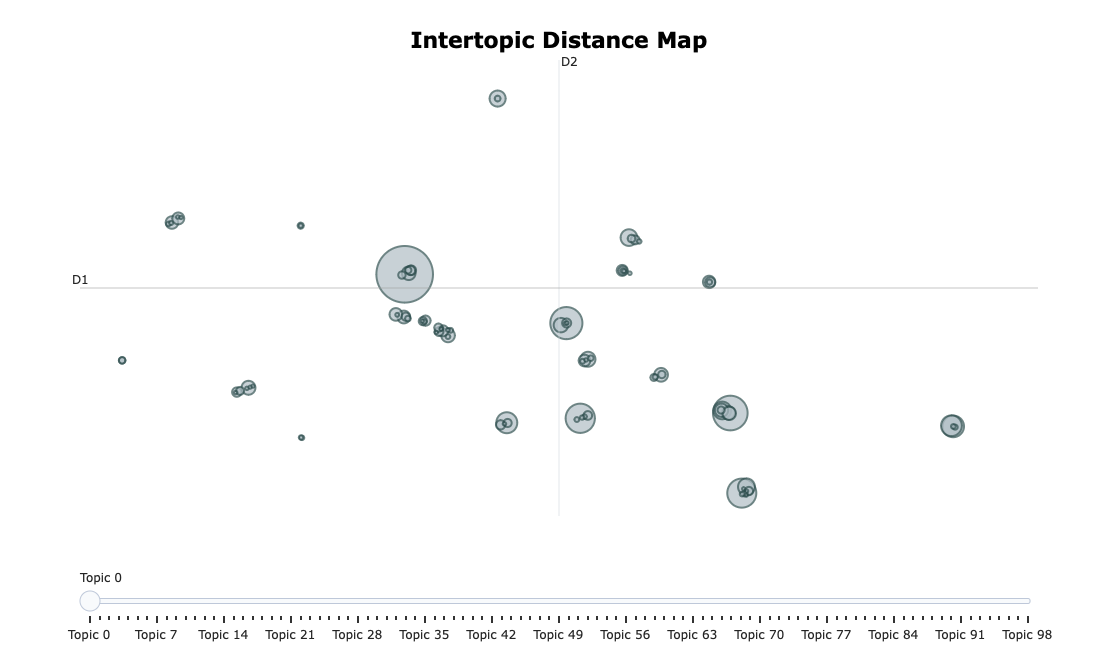

In [118]:
topic_model.visualize_topics( custom_labels = True )

2024-06-12 11:41:20,190 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 596) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


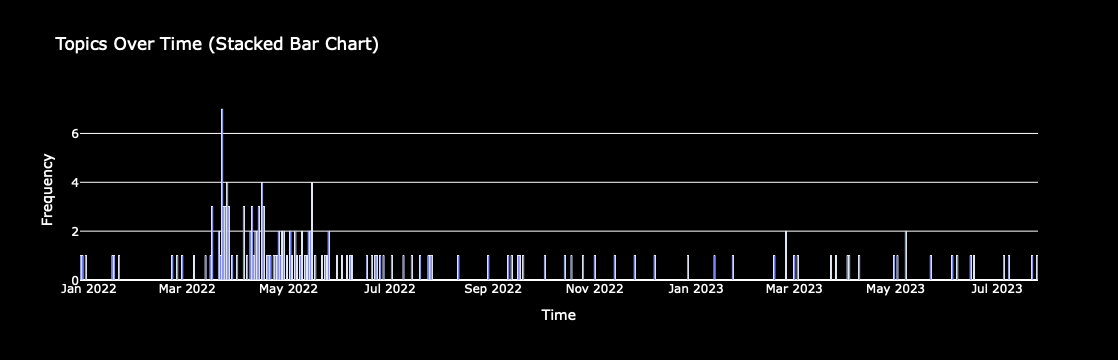

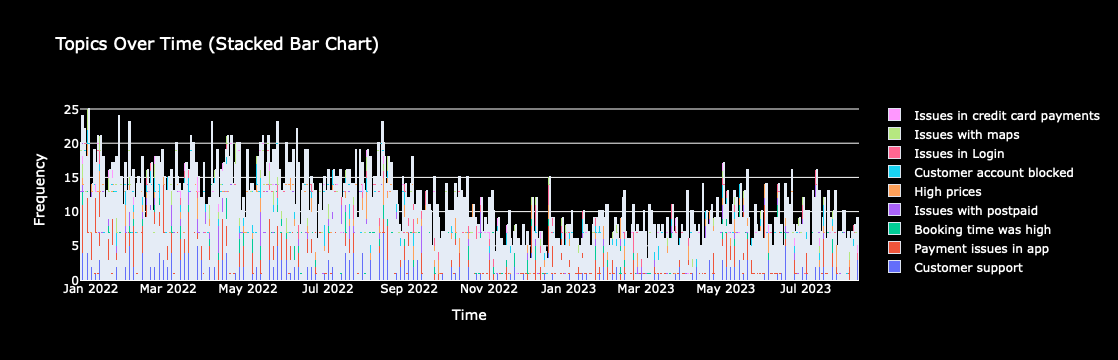

In [126]:
# 
# <--Post processing 4: Add date to use with topics over time-->
# 
# 

# Convert the review_date column to datetime format
df['review_date'] = pd.to_datetime(df['review_date'])

# Extract the year, month, and day and create a new column in YYYY-MM-DD format
df['review_ymd'] = df['review_date'].dt.strftime('%Y-%m-%d').astype(str)


# Get topics over time
topics_over_time = topic_model.topics_over_time(df['cleaned_review'].tolist(), df['review_ymd'])


fig_1 = topic_model.visualize_topics_over_time(topics_over_time, topics=[35], custom_labels = True)
fig_2 = topic_model.visualize_topics_over_time(topics_over_time, topics=[3,4,8,9,10,12,26,28,40], custom_labels = True)
# fig = topic_model.visualize_topics_over_time(topics_over_time)
fig_1_bar = convert_line_chart_to_bar_chart(fig_1)
fig_2_bar = convert_line_chart_to_bar_chart(fig_2)
# Display the plot inline in a Jupyter notebook
fig_1_bar.show()
fig_2_bar.show()

# Alternatively, save the plot to an HTML file
fig_1_bar.write_html("topics_over_time_1.html")
fig_2_bar.write_html("topics_over_time_2.html")

# print(topic_model.visualize_topics_over_time(topics_over_time, topics=[9, 10, 72, 83, 87, 91]))

In [125]:
# 
# <--Post processing 4: Add date to use with topics over time-->
# 
# 
import plotly.graph_objects as go

def convert_line_chart_to_bar_chart(fig):
    """
    Convert a Plotly line chart figure to a bar chart.

    Parameters:
    fig (plotly.graph_objects.Figure): The input line chart figure.

    Returns:
    plotly.graph_objects.Figure: The output bar chart figure.
    """
    # Extract data from the figure
    data = fig.data
    
    # Initialize a list to hold the traces for the bar chart
    bar_traces = []

    # Loop through the extracted data and convert line traces to bar traces
    for trace in data:
        # Extract x and y data from the trace
        x = trace['x']
        y = trace['y']
        name = trace['name']
        
        # Create a bar trace
        bar_trace = go.Bar(
            x=x,
            y=y,
            name=name
        )
        
        # Append the bar trace to the list
        bar_traces.append(bar_trace)

    # Create a new figure with the bar traces
    bar_fig = go.Figure(data=bar_traces)


    # Update layout for better visualization and set background color to black
    bar_fig.update_layout(
        title='Topics Over Time (Stacked Bar Chart)',
        xaxis_title='Time',
        yaxis_title='Frequency',
        barmode='stack',          # Stacked bar chart mode
        plot_bgcolor='black',     # Background color of the plotting area
        paper_bgcolor='black',    # Background color of the entire figure
        font=dict(color='white')  # Font color for text in the figure
    )

    return bar_fig

# Example usage:
# fig = topic_model.visualize_topics_over_time(topics_over_time, topics=[9, 10, 72, 83, 87, 91])
# bar_fig = convert_line_chart_to_bar_chart(fig)
# bar_fig.show()
